# Compute escape scores

TODO:
* data from escape calculator
    * simple: wget
    * complex: submodule
* ncov build
    * alignment and metadata
* turn into snakemake workflow?

In [2]:
import os
import sys
import glob
import pandas as pd
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Read in site-level escape values and other metadata from Jesse's escape calculator

In [3]:
# Read in site-level escape scores
escape_calc_resultsdir = '/fh/fast/matsen_e/hhaddox/2023/SARS2-RBD-escape-calc/results'
site_escape_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'escape.csv'))

# Read in dataframe specifying which studies the
# antibodies came from
ab_source_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'antibody_sources.csv'))

# Make a list of antibodies from the imprinted_2022 study
# to analyze below
imprinted_2022_abs = ab_source_df[
    ab_source_df['study'] == 'imprinted_2022'
]['antibody'].unique()

In [4]:
site_escape_df.head()

,antibody,site,escape
0,BD30-604,335,0.04938
1,BD30-604,340,0.05132
2,BD30-604,346,0.03290
3,BD30-604,365,0.07295
4,BD30-604,370,0.03994


Make a dataframe with site-specific amino-acid escape values, where each entry at each site is the site value from above. This dataframe is input for `dmsa-pred` below.

In [16]:
aa_escape_dict = defaultdict(list)
sites = list(set(site_escape_df['site']))
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
for (i, row) in site_df.iterrows():
    site = int(row.site)
    wt = str(row.wildtype)
    for mut in amino_acids:
        if wt == mut:
            continue
        aa_escape_dict['site'].append(site)
        aa_escape_dict['aa_sub'].append(f'{wt}{site}{mut}')

aa_escape_df = pd.DataFrame(aa_escape_dict)
aa_escape_df = aa_escape_df.merge(site_escape_df, on='site')
aa_escape_df.head()

,site,aa_sub,antibody,escape
0,331,N331A,BD55-5514,0.02983
1,331,N331A,CP0497,0.08276
2,331,N331A,BD57-0125,0.02136
3,331,N331A,BD57-0143,0.02517
4,331,N331A,BD57-0146,0.08997


In [17]:
aa_escape_df[aa_escape_df['antibody'] == imprinted_2022_abs[0]]

,site,aa_sub,antibody,escape
64106,338,F338A,1-57,0.06084
64147,338,F338C,1-57,0.06084
64188,338,F338D,1-57,0.06084
64229,338,F338E,1-57,0.06084
64270,338,F338G,1-57,0.06084
...,...,...,...,...
1972600,518,L518S,1-57,0.06236
1973088,518,L518T,1-57,0.06236
1973576,518,L518V,1-57,0.06236
1974064,518,L518W,1-57,0.06236


In [18]:
aa_escape_df.groupby('antibody').count()

,site,aa_sub,escape
antibody,,,
1-57,285,285,285
2-15,304,304,304
7D6,228,228,228
ADG-2,190,190,190
B38,437,437,437
...,...,...,...
XGv-416,209,209,209
XGv-418,380,380,380
XGv-420,285,285,285


Use dmsa-pred to make predictions on the imprinted_2022 data

In [19]:
resultsdir = 'results/cao_predictions/imprinted_2022_abs/escaped-clinically-approved-abs/'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)
alignment = 'results/escaped-clinically-approved-abs/translations/aligned.gene.S_withInternalNodes.fasta'
dms_wt_seq_id = 'Wuhan-Hu-1/2019'
mut_effect_col = 'escape'
mutation_col = 'aa_sub'

for (i, antibody) in enumerate(imprinted_2022_abs):
    
    continue

    # Write a dataframe with escape data for that antibody
    data = aa_escape_df[aa_escape_df['antibody'] == antibody].copy()
    mut_effects_df = os.path.join(resultsdir, f'{antibody}_mut_effects.csv')
    if os.path.isfile(mut_effects_df):
        continue
    data.to_csv(mut_effects_df, index=False)
    output_json = os.path.join(resultsdir, f'{antibody}_escape_pred.json')
    output_df = os.path.join(resultsdir, f'{antibody}_escape_pred.csv')
    
    # Run dmsa-pred
    print(i, antibody)
    cmd = ' '.join([
        'python',
        'my_profiles/dmsa-pred/dmsa_pred.py phenotype-prediction',
        '--model-type additive',
        f'--alignment {alignment}',
        f'--dms-wt-seq-id {dms_wt_seq_id}',
        f'--mut-effects-df {mut_effects_df}',
        f'--mut-effect-col {mut_effect_col}',
        f'--mutation-col {mutation_col}',
        '--mask-seqs-with-disallowed-aa-subs False',
        f'--experiment-label {antibody}',
        f'--output-json {output_json}',
        f'--output-df {output_df}'
    ])
    ! {cmd}

Read in dataframes with predicted escape scores and merge with metadata

In [20]:
# Read in predicted escape scores
fs = glob.glob(os.path.join(resultsdir, '*_escape_pred.csv'))
dfs = []
for f in fs:
    antibody = os.path.basename(f).replace('_escape_pred.csv', '')
    df = pd.read_csv(f)
    df['antibody'] = antibody
    dfs.append(df)
pred_df = pd.concat(dfs)
pred_df.rename(columns={'pred_phenotype':'escape_score'}, inplace=True)
pred_df = pred_df.merge(conv_ab_group_df, on='antibody', how='left')

# Read in metadata
metadata_f = 'results/escaped-clinically-approved-abs/escaped-clinically-approved-abs_subsampled_metadata.tsv.xz'
metadata_df = pd.read_csv(
    metadata_f,
    compression='xz', sep='\t', on_bad_lines='skip'
)

# Merge with prediction dataframe
pred_df = pred_df.merge(
    metadata_df[['strain', 'date', 'Nextstrain_clade']], on='strain'
)
pred_df['date'] = pd.to_datetime(pred_df['date'])
pred_df['time'] = (pred_df['date'] - pred_df['date'].min()).dt.days / 365

In [21]:
pred_df.to_csv(
    os.path.join(resultsdir, 'all_predictions.csv'),
    index=False
)

In [23]:
os.path.join(resultsdir, 'all_predictions.csv')

'results/cao_predictions/imprinted_2022_abs/escaped-clinically-approved-abs/all_predictions.csv'

In [22]:
len(pred_df['strain'].unique())

3510

<Axes: xlabel='escape_score', ylabel='Count'>

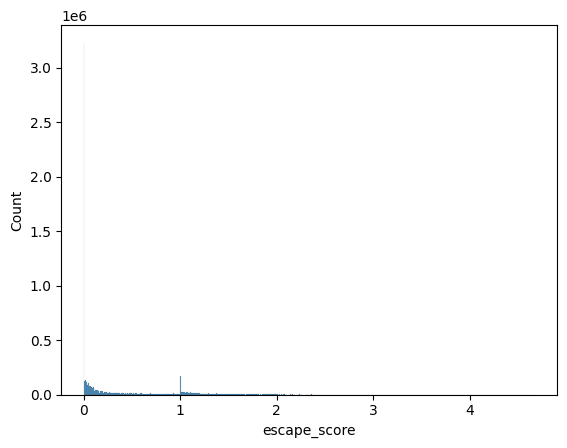

In [143]:
sns.histplot(pred_df['escape_score'])

In [133]:
sum(pred_df['aa_substitutions'].isnull())

3134590

In [134]:
len(pred_df)

8283996